In [109]:
# Try to use the GPU if possible
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

Device: cuda


In [110]:
import torch
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms

transform = transforms.ToTensor()
train_data = datasets.MNIST(root='data', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='data', train=False, download=True, transform=transform)

In [111]:
import torch
import torch.nn as nn

lat_v_size = 64
img_size = 28 * 28

class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = nn.Linear(img_size, lat_v_size)
        
    def forward(self, x):
        x = self.l1(x)
        return x

class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = nn.Linear(lat_v_size, img_size)
        
    def forward(self, x):
        x = self.l1(x)
        return x

In [112]:
def test_model(encoder, decoder, loss_fn, data_loader):
    original_states = encoder.training, decoder.training
    encoder.eval(), decoder.eval()
    total_loss = 0.0
    with torch.no_grad():
        for batch, _ in data_loader:
            batch = batch.to(device).reshape((-1, 1, 28*28))
            lat_v = encoder(batch)
            out = decoder(lat_v)
            total_loss += loss_fn(out, batch).item()
    encoder.train(original_states[0])
    decoder.train(original_states[1])
    return total_loss / len(test_loader)

In [113]:
from time import time
from tqdm import tqdm
epochs = 2
loss_fn = torch.nn.MSELoss().to(device)

batch_sizes = [8,16,32,64,128,256]

train_loss_curves = []
test_loss_curves = []
training_times = []
for bs in batch_sizes:
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=bs)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=bs)
    encoder = Encoder().to(device)
    decoder = Decoder().to(device)
    params_to_optimize = [
        {'params': encoder.parameters()},
        {'params': decoder.parameters()}
    ]
    opt = torch.optim.Adam(params_to_optimize, lr=1e-3)
    test_losses = [test_model(encoder, decoder, loss_fn, test_loader)]
    train_losses = []
    log_interv = 100
    encoder.train()
    decoder.train()
    start_t = time()
    for epoch in range(epochs):
        print(f"Batch size: {bs} epoch: {epoch}")
        for i, (batch, _) in enumerate(tqdm(train_loader)):
            batch = batch.to(device).reshape((-1, 1, 28*28))
            lat_v = encoder(batch)
            out = decoder(lat_v)
            loss = loss_fn(out, batch)
            train_losses.append(loss.cpu().detach().numpy())
            opt.zero_grad()
            loss.backward()
            opt.step()
            if i % log_interv == 0:
                test_losses.append(test_model(encoder, decoder, loss_fn, test_loader))
    training_times.append(time()-start_t)
    test_losses.append(test_model(encoder, decoder, loss_fn, test_loader))
    test_loss_curves.append(test_losses)


Batch size: 8 epoch: 0


100%|██████████| 7500/7500 [03:16<00:00, 38.09it/s]


Batch size: 8 epoch: 1


100%|██████████| 7500/7500 [04:12<00:00, 29.73it/s]


Batch size: 16 epoch: 0


100%|██████████| 3750/3750 [01:49<00:00, 34.32it/s]


Batch size: 16 epoch: 1


100%|██████████| 3750/3750 [01:50<00:00, 34.08it/s]


Batch size: 32 epoch: 0


100%|██████████| 1875/1875 [01:07<00:00, 27.83it/s]


Batch size: 32 epoch: 1


100%|██████████| 1875/1875 [00:56<00:00, 32.96it/s]


Batch size: 64 epoch: 0


100%|██████████| 938/938 [00:29<00:00, 31.68it/s]


Batch size: 64 epoch: 1


100%|██████████| 938/938 [00:32<00:00, 29.30it/s]


Batch size: 128 epoch: 0


100%|██████████| 469/469 [00:18<00:00, 25.29it/s]


Batch size: 128 epoch: 1


100%|██████████| 469/469 [00:19<00:00, 23.68it/s]


Batch size: 256 epoch: 0


100%|██████████| 235/235 [00:14<00:00, 15.99it/s]


Batch size: 256 epoch: 1


100%|██████████| 235/235 [00:14<00:00, 16.36it/s]


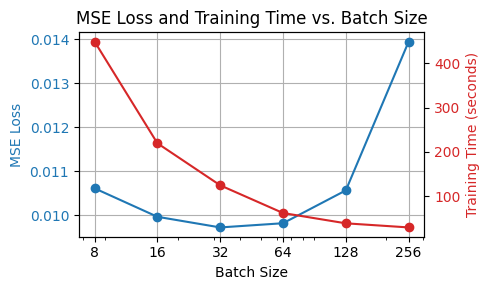

In [114]:
import matplotlib.pyplot as plt

r_mse        = [mse[-1] for mse in test_loss_curves]
fig, ax1 = plt.subplots(figsize=(5, 3))

# Plotting the MSE loss on the primary y-axis
color = 'tab:blue'
ax1.set_xlabel('Batch Size')
ax1.set_ylabel('MSE Loss', color=color)
ax1.plot(batch_sizes, r_mse, marker='o', linestyle='-', color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_xscale('log')
ax1.set_xticks(batch_sizes)
ax1.set_xticklabels(batch_sizes)
ax1.grid(True)

# Creating the secondary y-axis for training time
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Training Time (seconds)', color=color)
ax2.plot(batch_sizes, training_times, marker='o', linestyle='-', color=color)
ax2.tick_params(axis='y', labelcolor=color)

# Adding a title and showing the plot
plt.title('MSE Loss and Training Time vs. Batch Size')
fig.tight_layout()  # Adjust layout to make room for the dual y-axis
plt.show()